# Import

In [46]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from source.Prototype1 import Prototype1
from source.Classifier import MetalClassifier

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
from PIL import Image
from collections import deque
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter, label, generate_binary_structure
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.ndimage import label as ndi_label, binary_dilation

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Init Variables

In [3]:
model = Prototype1(num_attention_heads=16).to("cuda")
if torch.cuda.is_available():
    print("Using cuda cores")
    model.cuda()

dataset = NEUDataset(set="train", seed=555, scale=0.5, best_param=True, output_path="outputs_k10")

Using cuda cores
Dataset: train created!


# Hyper parameters

In [4]:
LEARNING_RATE = 0.0005
EPOCH = 1000
BATCH_SIZE = len(dataset)//2
THREADS = 8

# Training process
Best loss: '2532'

In [5]:
criterion = nn.MSELoss(reduction="sum")
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS)

In [ ]:
def train(model):
    loss_record = []
    for epoch in range(EPOCH):
        model.train()
        total_loss = 0
        num_batches = 0

        # Desempaquetar ignorando 'labels'
        for images, _, best_parameters in dataloader:
            images = images.to('cuda')
            best_parameters = best_parameters.to('cuda')

            # Forward: el modelo predice sp y sr
            pred_reg = model(images)  # salida de regresión

            # Calcular la pérdida de regresión
            loss = criterion(pred_reg, best_parameters)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_batches += 1

        avg_loss = total_loss / num_batches
        loss_record.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{EPOCH}], Loss: {avg_loss:.4f}")
    return loss_record, model

loss, model = train(model)

In [ ]:
total_parametros = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_parametros}")

In [ ]:
plt.plot(loss)           
plt.title("Line Chart")  
plt.xlabel("epoch")     
plt.ylabel("loss")      
plt.show()               

In [ ]:
#Guardar solo la red neuronal en un archivo .pth
torch.save(model.state_dict(), "h2.pth")
print("Modelo guardado exitosamente en h2.pth")

In [ ]:
loaded_model = Prototype1(num_attention_heads=16)
loaded_model.load_state_dict(torch.load("h2.pth", map_location=torch.device('cpu')))
loaded_model.to("cuda")
loaded_model.eval()

# Testing

In [6]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

def use_model_to_cluster(model: nn.Module, image: torch.tensor):
    best_parameters = model(image.to("cuda"))
    print(best_parameters)
    sp = best_parameters[0][0]
    if sp <= 1: sp = 1
    sr = best_parameters[0][1]
    if sr <= 1: sr = 1
    return sp, sr

def plot_how_the_model_is_watching_the_picture(model: nn.Module, dataset: NEUDataset):
    image, label = dataset.__getitem__(index= random.randint(0, len(dataset)))
    print(label)
    original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))
    sp , sr = use_model_to_cluster(loaded_model, image)
    clustered_image = Perspectiver.meanShift(original_image, float(sp), float(sr))
    Perspectiver.plotComparison(imageBefore=original_image, imageAfter=clustered_image)

In [7]:
test_set = NEUDataset(set="test", seed=55, scale=0.5, best_param=False)
#plot_how_the_model_is_watching_the_picture(loaded_model, test_set)

Dataset: test created!


# Using knowledge

In [54]:
LEARNING_RATE = 0.00005
EPOCH = 1200
BATCH_SIZE = len(dataset)
THREADS = 24
dataset = NEUDataset(set="train", seed=555, scale=0.5)
print(len(dataset))
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS)

Dataset: train created!
1656


In [55]:
def train(classifier, dataloader, criterion, optimizer):
    loss_record = []
    classifier.train()
    for epoch in range(EPOCH):
        total_loss = 0
        num_batches = 0

        # Desempaquetar ignorando 'labels'
        for images, label in dataloader:
            images = images.to('cuda')
            label = label[:, 0:6].float().to(device)

            # Forward: el modelo predice sp y sr
            pred_reg = classifier(images)  # salida de regresión

            #print(pred_reg.shape)
            #print(label.shape)

            loss = criterion(pred_reg, label)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_batches += 1

            #Opcional: imprimir para depurar
            #print("Logits:", pred_reg)
            #print("Labels:", label)
            #print("Batch Loss:", loss.item())

        avg_loss = total_loss / num_batches
        loss_record.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{EPOCH}], Loss: {avg_loss:.4f}")
    return loss_record, classifier

Best:  num_feature_extractors=2, features_per_extractor=6 ---> loss 24.012
Best:  num_feature_extractors=2, features_per_extractor=8 ---> loss 3.0934

In [56]:
classifier =  MetalClassifier(output_len=6, num_feature_extractors=2, features_per_extractor=8).to("cuda")
if torch.cuda.is_available():
    print("Using cuda cores")
    classifier.cuda()

total_parametros = sum(p.numel() for p in classifier.parameters())
print(f"Model parameters: {total_parametros}")

Using cuda cores
Model parameters: 1175448


In [57]:
loss, classifier = train(classifier=classifier, dataloader=dataloader, criterion=nn.CrossEntropyLoss(reduction="sum"), optimizer=torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE))

Epoch [1/1200], Loss: 2967.3906
Epoch [2/1200], Loss: 2967.3784
Epoch [3/1200], Loss: 2967.3665
Epoch [4/1200], Loss: 2967.3550
Epoch [5/1200], Loss: 2967.3435
Epoch [6/1200], Loss: 2967.3328
Epoch [7/1200], Loss: 2967.3225
Epoch [8/1200], Loss: 2967.3125
Epoch [9/1200], Loss: 2967.3022
Epoch [10/1200], Loss: 2967.2930
Epoch [11/1200], Loss: 2967.2842
Epoch [12/1200], Loss: 2967.2754
Epoch [13/1200], Loss: 2967.2676
Epoch [14/1200], Loss: 2967.2595
Epoch [15/1200], Loss: 2967.2520
Epoch [16/1200], Loss: 2967.2451
Epoch [17/1200], Loss: 2967.2383
Epoch [18/1200], Loss: 2967.2317
Epoch [19/1200], Loss: 2967.2258
Epoch [20/1200], Loss: 2967.2202
Epoch [21/1200], Loss: 2967.2148
Epoch [22/1200], Loss: 2967.2097
Epoch [23/1200], Loss: 2967.2051
Epoch [24/1200], Loss: 2967.2007
Epoch [25/1200], Loss: 2967.1963
Epoch [26/1200], Loss: 2967.1929
Epoch [27/1200], Loss: 2967.1890
Epoch [28/1200], Loss: 2967.1855
Epoch [29/1200], Loss: 2967.1824
Epoch [30/1200], Loss: 2967.1797
Epoch [31/1200], Lo

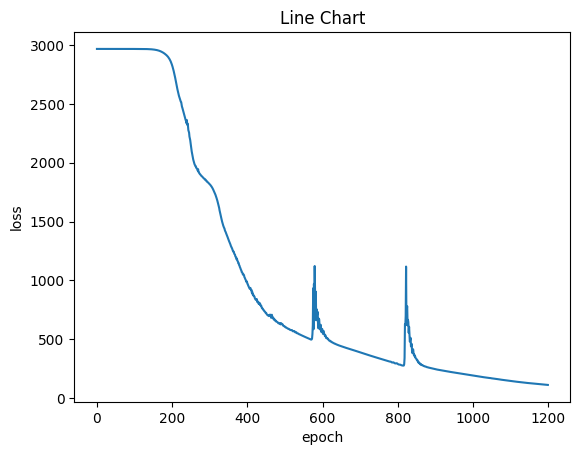

In [58]:
plt.plot(loss)           
plt.title("Line Chart")  
plt.xlabel("epoch")     
plt.ylabel("loss")      
plt.show()       

# Testing classifier

In [59]:
def prediction(image):
    # Envía la imagen a GPU, obtiene logits y selecciona la clase predicha.
    output = classifier(image.to("cuda"))
    pred_class = torch.argmax(output, dim=1)
    return pred_class

# Seleccionar una imagen aleatoria del conjunto de prueba
idx = random.randint(0, len(test_set) - 1)
image, label = test_set[idx]

# Evaluar sin calcular gradientes
with torch.no_grad():
    pred = prediction(image)

# Convertir etiqueta one-hot a índice si es necesario
if label.numel() > 1:
    true_class = torch.argmax(label)
else:
    true_class = label

print("Predicción:", pred.item())
print("Etiqueta real:", true_class.item())

Predicción: 1
Etiqueta real: 5


In [60]:
from sklearn.metrics import precision_score

# Listas para almacenar etiquetas verdaderas y predichas
true_labels = []
pred_labels = []

# Colocar el modelo en modo evaluación
classifier.eval()

# Desactivar cálculo de gradientes durante la evaluación
with torch.no_grad():
    for image, label in test_set:
        # Obtener la predicción (se asume que 'prediction' ya mueve la imagen a GPU)
        pred = prediction(image)
        
        # Convertir la etiqueta one-hot a índice, si es necesario
        if isinstance(label, torch.Tensor):
            label_idx = torch.argmax(label).item() if label.numel() > 1 else label.item()
        else:
            label_idx = label
        
        true_labels.append(label_idx)
        pred_labels.append(pred.item())

# Calcular la precisión (macro average)
precision = precision_score(true_labels, pred_labels, average='macro')
print("Precisión del modelo:", precision)


Precisión del modelo: 0.88003663003663


In [48]:
true_labels, pred_labels

([0,
  0,
  1,
  1,
  1,
  0,
  4,
  3,
  3,
  4,
  0,
  0,
  1,
  1,
  0,
  4,
  3,
  0,
  5,
  5,
  0,
  2,
  5,
  3,
  5,
  2,
  4,
  3,
  1,
  2,
  1,
  3,
  5,
  4,
  4,
  1,
  5,
  3,
  2,
  4,
  1,
  4,
  1,
  5,
  3,
  0,
  2,
  4,
  5,
  5,
  0,
  0,
  5,
  2,
  0,
  3,
  2,
  1,
  5,
  1,
  2,
  3,
  2,
  4,
  4,
  2,
  3,
  4,
  5,
  2,
  3,
  2],
 [4,
  4,
  1,
  2,
  1,
  4,
  4,
  3,
  3,
  3,
  2,
  4,
  1,
  1,
  4,
  4,
  3,
  3,
  5,
  5,
  4,
  2,
  5,
  3,
  5,
  2,
  3,
  3,
  0,
  2,
  1,
  3,
  5,
  3,
  4,
  1,
  5,
  3,
  2,
  3,
  2,
  4,
  1,
  5,
  3,
  4,
  2,
  4,
  5,
  5,
  4,
  4,
  5,
  2,
  4,
  3,
  2,
  1,
  5,
  1,
  2,
  3,
  3,
  4,
  4,
  2,
  3,
  4,
  5,
  2,
  3,
  2])

In [61]:
def evaluate_classification_metrics(df):
    """
    Calcula por clase (one-vs-rest):
      - Precision, recall, f1_score, accuracy y AUC ROC.
    Retorna un dataframe donde cada fila es una clase y la última fila es el promedio.
    """
    # Extraer etiquetas y clases
    y_true = df['GroundTruth'].values
    y_pred = df['Prediction'].values
    classes = np.unique(np.concatenate((y_true, y_pred)))
    
    # Binarizar etiquetas para one-vs-rest
    y_true_bin = label_binarize(y_true, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)
    
    records = []
    for i, cls in enumerate(classes):
        # Calcular métricas
        prec = precision_score(y_true_bin[:, i], y_pred_bin[:, i], zero_division=0)
        rec = recall_score(y_true_bin[:, i], y_pred_bin[:, i], zero_division=0)
        f1 = f1_score(y_true_bin[:, i], y_pred_bin[:, i], zero_division=0)
        acc = accuracy_score(y_true_bin[:, i], y_pred_bin[:, i])
        # AUC ROC requiere ambas clases en y_true
        auc = (roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
               if len(np.unique(y_true_bin[:, i])) > 1 else np.nan)
        
        records.append({
            'Clase': cls,
            'Precision': prec,
            'Recall': rec,
            'F1_score': f1,
            'Accuracy': acc,
            'AUC_ROC': auc
        })
    
    # Crear dataframe y agregar fila de promedio (macro)
    df_metrics = pd.DataFrame(records).set_index('Clase')
    df_metrics.loc['Promedio'] = df_metrics.mean(skipna=True)
    return df_metrics

def evaluate_model(y_pred: np.array, y_test: np.array, class_names_str: list):
    df_result = pd.DataFrame({"Prediction": y_pred, "GroundTruth": y_test})
    df_result["Prediction"] = df_result["Prediction"].apply(lambda x: class_names_str[x])
    df_result["GroundTruth"] = df_result["GroundTruth"].apply(lambda x: class_names_str[x])
    return evaluate_classification_metrics(df_result)

In [62]:
dataset.data

,Path,Rolled,Patches,Scratches,Inclusion,Pitted,Crazing
0,metal_dataset/train/Pitted/PS_262.bmp,0,0,0,0,1,0
1,metal_dataset/train/Inclusion/In_25.bmp,0,0,0,1,0,0
2,metal_dataset/train/Crazing/Cr_190.bmp,0,0,0,0,0,1
3,metal_dataset/train/Inclusion/In_182.bmp,0,0,0,1,0,0
4,metal_dataset/train/Crazing/Cr_227.bmp,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1651,metal_dataset/train/Scratches/Sc_35.bmp,0,0,1,0,0,0
1652,metal_dataset/train/Inclusion/In_6.bmp,0,0,0,1,0,0
1653,metal_dataset/train/Inclusion/In_291.bmp,0,0,0,1,0,0
1654,metal_dataset/train/Scratches/Sc_154.bmp,0,0,1,0,0,0


In [63]:
evaluate_model(y_pred=np.array(pred_labels), y_test=np.array(true_labels), class_names_str=["Rolled", "Patches", "Scratches", "Inclusion", "Pitted", "Crazing"])

,Precision,Recall,F1_score,Accuracy,AUC_ROC
Clase,,,,,
Crazing,0.857143,1.000000,0.923077,0.972222,0.983333
Inclusion,0.923077,1.000000,0.960000,0.986111,0.991667
Patches,1.000000,0.833333,0.909091,0.972222,0.916667
Pitted,1.000000,0.916667,0.956522,0.986111,0.958333
Rolled,0.750000,0.750000,0.750000,0.916667,0.850000
Scratches,0.750000,0.750000,0.750000,0.916667,0.850000
Promedio,0.880037,0.875000,0.874782,0.958333,0.925000


In [ ]:
#Guardar solo la red neuronal en un archivo .pth
torch.save(classifier.state_dict(), "classifier.pth")
print("Modelo guardado exitosamente en classifier.pth")